In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import ImageFolder
import albumentations as A
import torchvision
# # Load CLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator, sam_model_registry
from PIL import Image, ImageDraw
import clip
import torch
import numpy as np

/ext3/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = A.Compose(
        [
            A.Resize(224, 224, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ]
    )

In [3]:
# Set the path to your dataset folder
dataset_path = '/scratch/sg7729/DL_project/Evaluate/stitched_images'


In [4]:
df = pd.read_csv('/scratch/sg7729/DL_project/Evaluate/stitched_images/stitched_images.csv')

In [6]:
sam_checkpoint = "/scratch/sg7729/DL_project/SLIP/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
      (1): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, b

In [7]:
# Download the model weights to load them here
mask_generator = SamAutomaticMaskGenerator(
        model = sam,
        points_per_side = 16,
        pred_iou_thresh =  0.9,
        min_mask_region_area = 1,
        crop_overlap_ratio = 0.8 )

In [8]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

In [9]:
def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

In [10]:
def filter_annotations(annotations):
    annotations.sort(key=lambda x: x['area'], reverse=True)
    to_remove = set()
    for i in range(0, len(annotations)):
        a = annotations[i]
        for j in range(i + 1, len(annotations)):
            b = annotations[j]
            if i != j and j not in to_remove:
                # check if 
                if b['area'] < a['area']:
                    if (a['segmentation'] & b['segmentation']).sum() / b['segmentation'].sum() > 0.8:
                        # print('area')
                        to_remove.add(j)
#                         print(i, j)
#     print(to_remove)
    return [a for i, a in enumerate(annotations) if i not in to_remove]

In [11]:
class config:
    image_path = "/scratch/sg7729/DL_project/SLIP/Images"
    captions_path = "/scratch/sg7729/DL_project/SLIP/"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    text_tokenizer = "distilbert-base-uncased"

In [12]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames # one description per image
        self.captions = list(captions) # one description per image
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=200
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

#         image = cv2.imread(f"{config.image_path}/{self.image_filenames[idx]}")
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = self.transforms(image=image)['image']
        item['image'] = [1]
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)

In [13]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name='resnet50', pretrained=True, trainable=True
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [14]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{config.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = A.Compose(
        [
            A.Resize(224, 224, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ]
    )
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        num_workers=2,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [15]:
# dataframe, _ = make_train_valid_dfs()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_df, valid_df = make_train_valid_dfs()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_loader = build_loaders(train_df, tokenizer, mode="train")
valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


In [16]:
class TextEncoder(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", pretrained=True, trainable=True):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [17]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=128,
        dropout=0
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [18]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=1,
        image_embedding=2048,
        text_embedding=768,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        batch_size = len(image_embeddings) 
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [19]:
def get_masks_embeddings(model, masks): 
    model.eval()
    # Apply transforms
    transforms = A.Compose(
        [
            A.Resize(224, 224, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ],
    )

    
    processed_masks = []
    
    for mask in masks:
#         print(mask)
        mask = np.array(mask)
#         print(mask.shape)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = transforms(image=mask)['image']
        mask = np.transpose(mask, (2, 0, 1))
#         print(mask.shape)
        processed_masks.append(mask)
        
    processed_masks = torch.tensor(processed_masks)
#     print(processed_masks.shape)

    mask_image_embeddings = []
    with torch.no_grad():
        image_features = model.image_encoder(processed_masks.to(device))
        image_embeddings = model.image_projection(image_features)
        mask_image_embeddings.append(image_embeddings)
    return torch.cat(mask_image_embeddings)

In [20]:
def find_matching_masks(model, image_embeddings, query, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(config.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(config.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), 1)
#     print(dot_similarity)
    return dot_similarity, values

In [21]:
model = CLIPModel().to(device)
model.load_state_dict(torch.load('/scratch/sg7729/DL_project/SLIP/TrainL_Metric: 0.3710_ValidL_Metric: 0.7791_Epoch_99.pt'))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [22]:
dataset_resnet = torchvision.datasets.ImageFolder(root='/scratch/sg7729/DL_project/SLIP/extra_dataest/dataset/', transform=transform)

In [23]:
len(dataset_resnet.classes)

149

In [24]:
resnet_model = torchvision.models.resnet18(pretrained=False)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, len(dataset_resnet.classes))


/ext3/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ext3/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [25]:

resnet_model.load_state_dict(torch.load('/scratch/sg7729/DL_project/Classifier/resnet1876.17260787992495.pth'))

<All keys matched successfully>

In [26]:
# Define the transformation to be applied to each image
resnet_transform = transforms.Compose(
    [transforms.Resize((224, 224)),  # Resize the image to 224x224
     transforms.ToTensor(),  # Convert the image to a PyTorch tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize the image

In [64]:
images = df['images'].tolist()
class_list = df['classes'].tolist()
correct = 0
wrong = []
counter = 0
for i, image in enumerate(images):
    
    image_path = dataset_path + '/' + image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(img)
    annotations =  masks
    new_annotaions = filter_annotations(annotations)
    new_annotaions.pop(0)

    image = Image.open(image_path)
    cropped_boxes = []

    for mask in new_annotaions:
        cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))
    
    mask_image_embeddings = get_masks_embeddings(model, cropped_boxes)

    classes_paths = class_list[i].split('_')
    classes_paths.pop()
    classes = []
    for c in classes_paths:
        index = c.split('/')[-1]
        if "-" in index:
            index = index.split('-')[0]
        index = index.split('.')[0]
        correct_label = list(pokedex[pokedex['Name'] == int(index)]['Type 1'])[0]
        classes.append(correct_label)
    for cl in classes:
        scores, values = find_matching_masks(model, mask_image_embeddings, cl)
        max_idx = torch.argmax(scores)
        predicted_segment = cropped_boxes[max_idx]

        transformed_segment =  resnet_transform(predicted_segment)
        transformed_segment =  transformed_segment.view(1, 3, 224, 224)
        resnet_model.eval()
        with torch.no_grad():
            predicted_resnet_label = resnet_model(transformed_segment)
            predicted_resnet_label = torch.argmax(predicted_resnet_label)
            predicted_class = dataset_resnet.classes[predicted_resnet_label]
        print(predicted_class, cl)
        if predicted_class.lower() == cl.lower():
            correct += 1
        else:
            wrong.append(predicted_segment)
        
        counter += 1
        if counter % 50 == 0:
            accuracy = correct / counter
            print(f"Accuracy after {counter} images: {accuracy}")
print(f"Final accuracy: {correct / counter}")


Scyther Scyther
Hitmonlee Hitmonlee
Fearow Fearow
Venomoth Venomoth
Grimer Grimer
Voltorb Beedrill
Voltorb Mew
Weezing Weezing
Krabby Krabby
Slowbro Slowbro
Pidgeotto Pidgeotto
Jolteon Jolteon
Psyduck Dodrio
Kangaskhan Kangaskhan
Psyduck Mr. Mime
Weedle Weedle
Hypno Zapdos
Machop Machop
Dratini Dratini
Electrode Electrode
Pinsir Pinsir
Psyduck Abra
Parasect Magmar
Seaking Seaking
Venusaur Venusaur
Pidgey Pidgey
Mewtwo Mewtwo
Clefairy Clefairy
Muk Cloyster
Venusaur Venusaur
Dewgong Kabutops
Poliwhirl Poliwrath
Seel Seel
Growlithe Growlithe
Primeape Primeape
Seel Seel
Raticate Raticate
Charmander Doduo
Raticate Seadra
Psyduck Mr. Mime
Psyduck Blastoise
Charizard Charizard
Weepinbell Weepinbell
Rattata Rattata
Nidorino Nidorino
Kangaskhan Kangaskhan
Golduck Golduck
Hitmonchan Hitmonchan
Lickitung Lickitung
Parasect Parasect
Accuracy after 50 images: 0.72
Haunter Haunter
Haunter Zapdos
Weepinbell Tentacruel
Psyduck Gastly
Weepinbell Victreebel
Rhydon Rhydon
Clefairy Clefairy
Ekans Ekans
Du

In [36]:
pokedex = pd.read_csv('/scratch/sg7729/DL_project/Evaluate/pokedex.csv')

In [ ]:
images = df['images'].tolist()
class_list = df['classes'].tolist()
correct = 0
wrong = []
counter = 0
for i, image in enumerate(images):
    
    image_path = dataset_path + '/' + image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(img)
    annotations =  masks
    new_annotaions = filter_annotations(annotations)
    new_annotaions.pop(0)

    image = Image.open(image_path)
    cropped_boxes = []

    for mask in new_annotaions:
        cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))
    
    mask_image_embeddings = get_masks_embeddings(model, cropped_boxes)

    classes_paths = class_list[i].split('_')
    classes_paths.pop()
    classes = []
    for c in classes_paths:
        index = c.split('/')[-1]
        if "-" in index:
            index = index.split('-')[0]
        index = index.split('.')[0]
        correct_label = list(pokedex[pokedex['Name'] == int(index)]['Type 1'])[0]
        classes.append(correct_label)
    for cl in classes:
        scores, values = find_matching_masks(model, mask_image_embeddings, cl)
        valu, max_idxs = torch.topk(scores, k=min(5, len(scores)))
        predicted_segments = []
        
        for idx in max_idxs[0]:
#             print(idx)
            predicted_segments.append(cropped_boxes[idx])
        
        for predicted_segment in predicted_segments:
            transformed_segment =  resnet_transform(predicted_segment)
            transformed_segment =  transformed_segment.view(1, 3, 224, 224)
            resnet_model.eval()
            with torch.no_grad():
                predicted_resnet_label = resnet_model(transformed_segment)
                predicted_resnet_label = torch.argmax(predicted_resnet_label)
                predicted_class = dataset_resnet.classes[predicted_resnet_label]
#             print(predicted_class, cl)
            if predicted_class.lower() == cl.lower():
                correct += 1
                break
            else:
                wrong.append(predicted_segment)
        
        counter += 1
        if counter % 50 == 0:
            accuracy = correct / counter
            print(f"Accuracy after {counter} images: {accuracy}")
print(f"Final accuracy: {correct / counter}")


Accuracy after 50 images: 0.72
Accuracy after 100 images: 0.68
Accuracy after 150 images: 0.7


In [62]:
class_list = df['classes'].tolist()
classes_paths = class_list[94].split('_')
classes_paths.pop()
for c in classes_paths:
    index = c.split('/')[-1]
    if "-" in index:
        index = index.split('-')[0]
    index = index.split('.')[0]
    correct_label = list(pokedex[pokedex['Name'] == int(index)]['Type 1'])[0]
    print(correct_label, index)
   

Nidoran♂ 32
Omastar 139
Blastoise 9
Gyarados 130


In [57]:
correct_label = list(pokedex[pokedex['Name'] == 77]['Type 1'])[0]
correct_label

'Ponyta'

In [63]:
images = df['images'].tolist()
class_list = df['classes'].tolist()
correct = 0
wrong = []
masks_p = []
counter = 0
for i, image in enumerate(images):
    
    image_path = dataset_path + '/' + images[4]
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(img)
    annotations =  masks
    print(len(masks))
#     new_annotaions = filter_annotations(annotations)
#     new_annotaions.pop(0)

    image = Image.open(image_path)
    cropped_boxes = []
    annotations.sort(key=lambda x: x['area'], reverse=True)
    for mask in annotations:
        cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))
    print(len(cropped_boxes))

    mask_image_embeddings = get_masks_embeddings(model, cropped_boxes)

    classes_paths = class_list[i].split('_')
    classes_paths.pop()
    classes = []

    print()
    for cl in classes:
        scores, values = find_matching_masks(model, mask_image_embeddings, cl)
        max_idx = torch.argmax(scores)
        predicted_segment = cropped_boxes[max_idx]

        transformed_segment =  resnet_transform(predicted_segment)
        transformed_segment =  transformed_segment.view(1, 3, 224, 224)
        resnet_model.eval()
        with torch.no_grad():
            predicted_resnet_label = resnet_model(transformed_segment)
            predicted_resnet_label = torch.argmax(predicted_resnet_label)
            predicted_class = dataset_resnet.classes[predicted_resnet_label]

        if predicted_class == cl:
            correct += 1
        else:
            wrong.append(predicted_segment)
        
        counter += 1
        if counter % 10 == 0:
            accuracy = correct / counter
            print(f"Accuracy after {counter} images: {accuracy}")
    break
print(f"Final accuracy: {correct / counter}")


35
35


/state/partition1/job-33171204/ipykernel_329654/1272000257.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  processed_masks = torch.tensor(processed_masks)


Final accuracy: 0.0


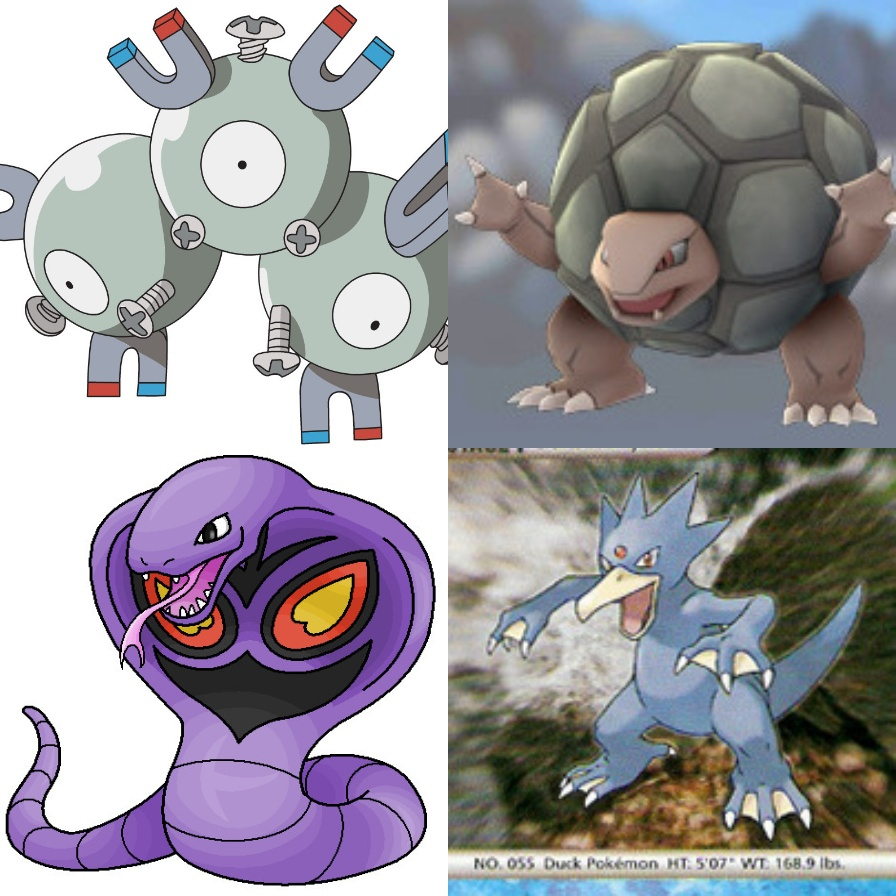

In [173]:
Image.open(dataset_path + '/' + images[4])

In [146]:
class_list[4]

'Magneton_Golem_Arbok_Golduck_'

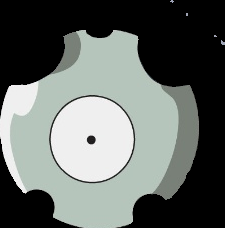

In [155]:
cropped_boxes[7]

In [128]:
resnet_model.eval()
transformed_segment =  resnet_transform(cropped_boxes[4])
transformed_segment =  transformed_segment.view(1, 3, 224, 224)
with torch.no_grad():
    predicted_resnet_label = resnet_model(transformed_segment)
    predicted_resnet_label = torch.argmax(predicted_resnet_label)
    predicted_class = dataset_resnet.classes[predicted_resnet_label]
print(predicted_class)

Gengar


In [168]:
scores, values = find_matching_masks(model, mask_image_embeddings, 'Golduck')
max_idx = torch.argmax(scores)

In [169]:
max_idx

tensor(5, device='cuda:0')

In [170]:
scores

tensor([[0.7195, 0.7027, 0.6788, 0.7177, 0.7101, 0.7881, 0.7363, 0.7101, 0.7397,
         0.7193, 0.7088, 0.6715, 0.6795, 0.7533, 0.7238, 0.6904, 0.7212, 0.6957,
         0.7327, 0.7042, 0.7172, 0.7355, 0.6862, 0.7461, 0.7064, 0.7187, 0.7194,
         0.7033, 0.7291, 0.7081, 0.7093, 0.7099, 0.7181, 0.7102, 0.7258, 0.7580,
         0.7312, 0.6901, 0.7105, 0.7295, 0.7193, 0.7309, 0.7284, 0.7541, 0.7061,
         0.6725, 0.7214, 0.7497, 0.6623, 0.6696, 0.7081, 0.6986, 0.7525, 0.7208,
         0.6981, 0.6895, 0.7098, 0.7210, 0.7453, 0.7091, 0.7208, 0.7228]],
       device='cuda:0')

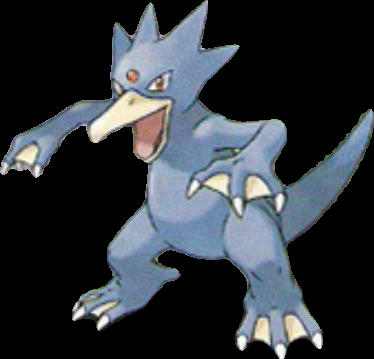

In [171]:
cropped_boxes[max_idx]